<center><h1><font color='red'> Guide 6 |  Unsupervised Automated Behavioral Analysis </font></h1></center>

In this guide, we will be synthesizing everything we've learned so far. More specifically, we are going to automatically and computationally analyze an ant's behavior over the course of a video using data analytics and unsupervised machine learning tools!

## Objectives
- Understand how the various techniques that we've covered over the semester work together to analyze behavior
- Learn how to engineer features that describe behavior



## Table of Contents:
0. Extract and Format Data
1. Preprocessing
2. Feature Engineering
3. Unsupervised Machine Learning
4. Ethogram: Visualize the Results!

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
from glob import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## 0. Extract and Format Data

As always, the first step today will be to extract our data from the h5 file and read it into a numpy array. If you would like a refresher as to the specifics behind each step here, please check out the "Deeplabcut h5 Data" section of guide3!

In [7]:
for path in glob("data/*.h5"):
    print(path)

data/maj_20181005_dP_food1_60-838DeepCut_resnet50_small_arenaJun18shuffle1_1030000.h5


In [8]:
dP_path = "data/maj_20181005_dP_food1_60-838DeepCut_resnet50_small_arenaJun18shuffle1_1030000.h5"

# extract data from h5
store = pd.HDFStore(dP_path, mode='a')
df = store['df_with_missing']
store.close()

# format data to into numpy array
x_data = df.xs('x', level="coords", axis=1).to_numpy()
y_data = df.xs('y', level="coords", axis=1).to_numpy()
dP_data = np.concatenate((
    np.expand_dims(x_data, axis=-1), 
    np.expand_dims(y_data, axis=-1)), axis=-1)
print(dP_data.shape)

(779, 30, 2)


## 1. Preprocessing

Before we start building the features that we'll analyze using unsupervised machine learning, we need to preprocess our data. To do this, we will be performing two key steps. First, we will translate each body point so that our data is centered around the ant's center. This is an important step because we want to analyze the location of each body point relative to the center of the ant, not relative to its location on the stage. Next, we will be rotationally correcting our data so that the ant is always pointing in the same direction. This will help us focus on the ant's behavior at each point rather than its orientation.


If you would like a refresher on how/why the translational and rotational correction techniques we use below work, please check out the "Preprocessing" section of guide3!

In [9]:
# Translational Correction
trans_dP_data = dP_data - dP_data[:,2,:][:,np.newaxis,:]

In [10]:
# Rotational Correction

# compute ant's axis for each frame
axis = trans_dP_data[:,1,:] - trans_dP_data[:,2,:]

# compute angle between ant's axis and vertical axis
angles = np.sign(axis[:,0]) * np.pi/2 - np.arctan( axis[:,1]/axis[:,0] )

# rotational matrix
num_fr,_,_ = dP_data.shape
rot_dP_data = []
for fr in range(num_fr):
    angle = angles[fr]
    rotation_matrix = np.array([[np.cos(angle), -1*np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rot_data = np.matmul(rotation_matrix, trans_dP_data[fr,:,:].T).T
    rot_dP_data.append(rot_data)
rot_dP_data = np.stack(rot_dP_data)
print(rot_dP_data.shape)

(779, 30, 2)


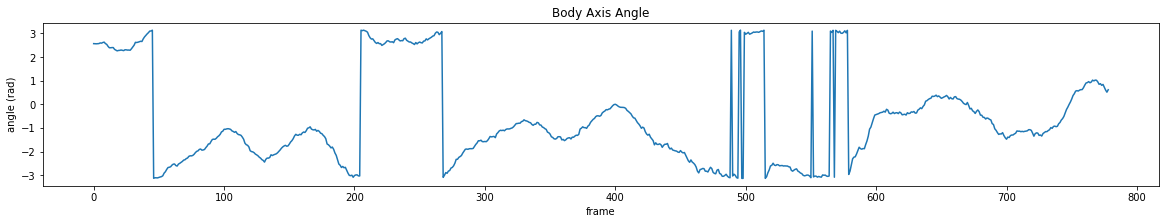

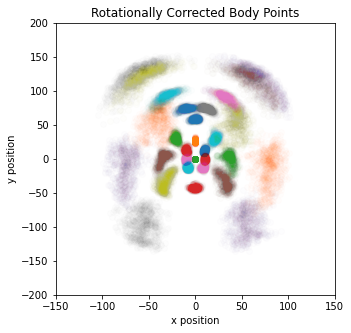

In [11]:
# plot pre-rotation body axis angle
fig, ax = plt.subplots(figsize=(20,3))
plt.plot(angles)
plt.xlabel("frame"); plt.ylabel("angle (rad)"); plt.title(f"Body Axis Angle")
plt.show()

# plot rotationally corrected ant body points
fig, ax = plt.subplots(figsize=(5,5))
for i in range(30):
    plt.scatter(rot_dP_data[:,i,0], rot_dP_data[:,i,1], alpha=0.01)
plt.xlabel("x position"); plt.ylabel("y position"); plt.title(f"Rotationally Corrected Body Points")
plt.xlim([-150, 150]);plt.ylim([-200, 200])
plt.show()

## 2. Feature Engineering

We now have a dataset of rotationally and translationally corrected body points for the ant in every frame. Given that our goal is to extract the different behaviors that the ant shows over time from this data, the natural question then is: what features of the ant's posture best highlight its behavior?

As it turns out, the angles between different body points and the verticle axis of the ant are quite useful when it comes to analyzing behavior. This is because much of the information about how an insect (or animal) is moving, and therefore, behaving, comes from the frequency at which these angles change. This may not seem that intuitive at first, but think, for instance, about how you might figure out whether a person is standing, walking, jogging, or sprinting. Could we use the frequency at which the angle between, say, the person's legs changes to determine this?

Now that we know that the frequency at which different postural angles change is indicative of an ant's behavior, we must create the features that describe this. We will achieve this in two steps. First, we need to calculate the angle between each body point and the ant's verticle axis. Second, we must apply the signal processing techniques from guide 4 to these angles to determine the frequencies at which they are changing in any given frame. From the resulting features, our unsupervised machine learning models should be able to accurately distinguish different types of movement, and therefore, behaviors!



Note: throughout this process, we will be analyzing all of the ant's body points. Just so we don't overwhelm ourselves, though, we will only be visualizing one. For no reason in particular, let's visualize the features we create from body point 8!

#### 2.0 Calculate the angles

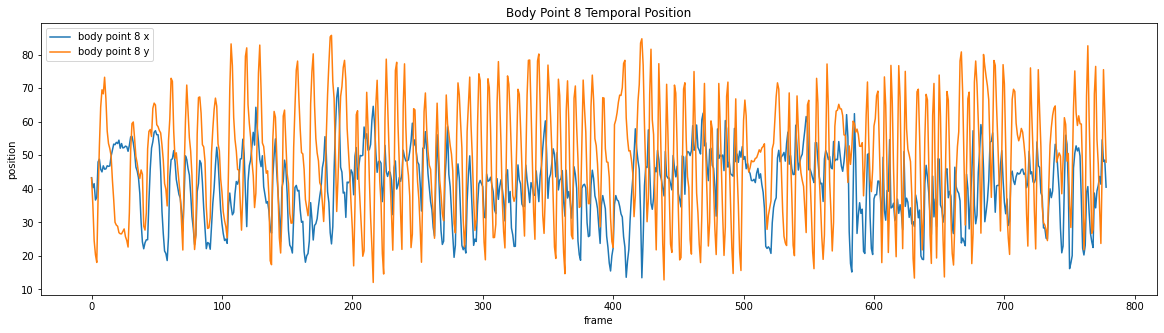

In [12]:
# body point to analyze
bp_i = 8

# plot body point 8's x and y coordinates over time
fig, ax = plt.subplots(figsize=(20,5))

plt.plot(rot_dP_data[:,bp_i,0], label=f"body point {bp_i} x")
plt.plot(rot_dP_data[:,bp_i,1], label=f"body point {bp_i} y")

plt.legend()
plt.xlabel("frame"); plt.ylabel("position"); plt.title(f"Body Point {bp_i} Temporal Position")
plt.show()

Here, we will calculate the angle that each body point makes with the ant's verticle axis, using the center of the ant (bp2) as the angle's vertex. Do you recognize the method that we use to calculate this angle from when we rotationally corrected our data?

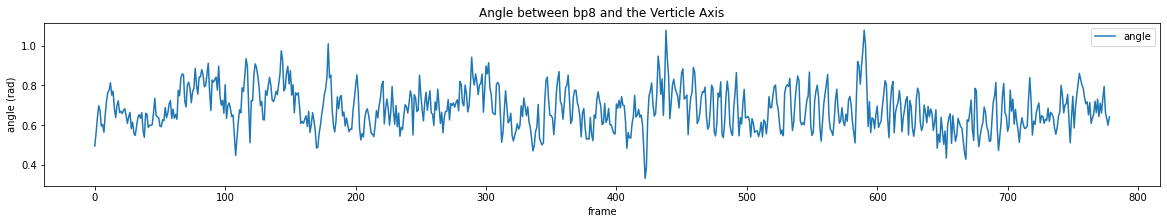

In [13]:
dp_angles = []

for bp_i in range(30):
    if bp_i in (1,2): # these angles define the ant's verticle axis
      continue
    # compute body point's axis for each frame
    axis = rot_dP_data[:,bp_i,:] - rot_dP_data[:,2,:]
    # compute angle between body point's axis and vertical axis
    angles = np.sign(axis[:,0]) * np.pi/2 - np.arctan(axis[:,1] / axis[:,0])
    dp_angles.append(angles)

dp_angles = np.stack(dp_angles).T

# plot arm angle signal
bp_i = 8

fig, ax = plt.subplots(figsize=(20,3))
plt.plot(dp_angles[:,bp_i], label="angle")
plt.xlabel("frame"); plt.ylabel("angle (rad)"); plt.title(f"Angle between bp{bp_i} and the Verticle Axis")
plt.legend()
plt.show()

#### 2.1 Signal Processing

As we discussed earlier, now that we have our angles, we need to use signal processing to calculate the different frequencies at which each angle is changing in every frame. To give you a high level overview, we will first filter our data using a bandpass filter, and then we will calculate the power of 100 different frequencies for each angle in every frame using a wavelet transform. If you would like a refresher on any of these techniques, I encourage you to look back on guide 4!

In [14]:
# filter our data using a bandpass filter
from scipy.signal import butter, lfilter

fps=50
lowcut = 0.7 # lower frequency threshold
highcut = 20  # upper frequency threshold
order = 1

nyq = 0.5 * fps
low = lowcut / nyq
high = highcut / nyq

b, a = butter(order, [low, high], btype='band')
signal_filt = lfilter(b, a, dp_angles, axis=0)

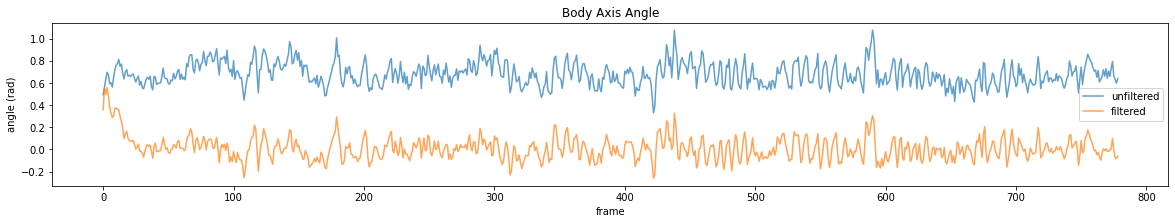

In [15]:
# plot filtered and unfiltered data for the bp8 angle feature
bp_i=8

fig, ax = plt.subplots(figsize=(20,3))
plt.plot(dp_angles[:,bp_i], alpha=0.7, label="unfiltered")
plt.plot(signal_filt[:,bp_i], alpha=0.7, label="filtered")
plt.xlabel("frame"); plt.ylabel("angle (rad)"); plt.title(f"Body Axis Angle")
plt.legend()
plt.show()

In [16]:
# create new features by analyzing our angle features using a wavelet transform
from scipy.signal import morlet2, cwt, convolve, ricker

w = 5
freq = np.linspace(1, fps/2, 100)
widths = w*fps / (2*freq*np.pi)

pwr=[]
for bp_i in range(28):
    cwtm = cwt(signal_filt[:,bp_i], morlet2, widths, dtype=None, w=w)
    power = np.abs(cwtm*freq[:, np.newaxis])**2
    pwr.append(power)
pwr = np.stack(pwr).T

# pwr is a array of power values with shape (frame,frequency,angle)
print(pwr.shape)

(779, 100, 28)


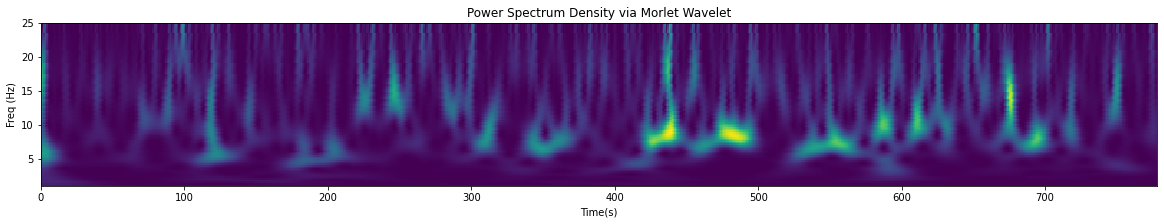

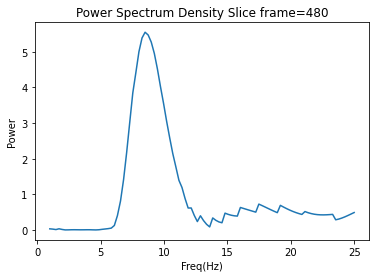

In [17]:
# plot the power spectrum of bp8's angle over time
bp_i = 8

fig, ax = plt.subplots(figsize=(20,3))
ax.pcolormesh(range(num_fr), freq, pwr[:,:,bp_i].T, cmap='viridis')
plt.xlabel("Time(s)"); plt.ylabel("Freq (Hz)"), plt.title("Power Spectrum Density via Morlet Wavelet")
plt.show()

# plot the power spectrum for bp8's angle in one frame
fr = 480
plt.plot(freq, pwr[fr,:,bp_i])
plt.xlabel("Freq(Hz)"); plt.ylabel("Power"), plt.title(f"Power Spectrum Density Slice frame={fr}")
plt.show()

Notice the data that we have now. Rather than an array of the ant's body point locations over time, we now have an array of the power of 100 different frequencies for each angle over time!

## 3. Unsupervised machine learning

Now that we've engineered some features that describe the ant's behavior, it's time to analyze them in a way that will tell us which behaviors the ant performs, and when! Remember, though, we do not yet know which behaviors are present in the video -- we want our model to figure this out for us. In other words, we want our model to derive the labels (in this case, the behaviors) from our features (the frequencies for each angle). This means that we need to use unsupervised machine learning!

More specifically, we first want to reduce the dimensionality of our data using manifold learning, and then we want to cluster our data using a clustering algorithm. These two steps will work together to find patterns in our features and identify "clusters" of distinct behaviors that the ant performs over the course of the video! If you would like a refresher on what either of these steps are or why they are important, I encourage you to look back on the "Unsupervised Learning" section of guide 5.

#### 3.0 Manifold Learing: UMAP

First, just like we did in guide 5, we will use a manifold learning model to reduce the dimensionality of our data so that we can visualize and cluster it in a 2D embedding space. Please don't be scared by the fact that we're using a new type of manifold learning model (UMAP). It performs a very similar job to t-SNE (the model that we used in guide 5), and it's implemented in a very similar manner. The reason that we use UMAP instead of t-SNE here is because sometimes one model creates a "better" 2D embedding space than the other, so it's always good to have been exposed to both!

If you are curious about the specifics behind [how umap works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html) or its [parameters](https://umap.scikit-tda.org/parameters.html), please check out the linked guides!

In [ ]:
# for those on google colab
!pip install umap-learn

In [ ]:
import umap

# reshape the pwr array so that is has the shape (num_frames,num_features)
# in guide 5, our arrays already had this shape, so we didn't need this step
num_fr, num_freq, num_bp = pwr.shape
pwr_reshaped = pwr.reshape(num_fr, num_freq*num_bp)

# use umap to create our 2D embedding
reducer = umap.UMAP(n_epochs=2000, random_state=41)
embedding = reducer.fit_transform(pwr_reshaped)
print(embedding.shape)

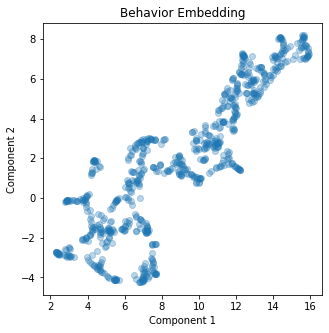

In [20]:
# plot a point for each frame in our embedding space
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(embedding[:,0], embedding[:,1], alpha=0.3)
plt.xlabel("Component 1"); plt.ylabel("Component 2"); plt.title(f"Behavior Embedding")
plt.show()

#### Clustering: 3.1 MeanShift

Once again, since it is always good to learn about new models, instead of using KMeans Clustering or DBSCAN to cluster our data like we did in guide 5, today we're going to show you MeanShift! Just like when we use DBSCAN, we do not need to specify the number of clusters that we want MeanShift to identify. Rather, we just specify certain input parameters, and it determines the number of clusters, as well as their locations, for us! If you would like to learn more about MeanShift, please check out scikit learn's [guide](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html). If you would like a refresher on what clustering algorithms are or why we use them, please refer back to guide 5!

In [25]:
from sklearn.cluster import MeanShift

# use MeanShift to cluster our embedding data
MeanShift_model = MeanShift(bandwidth=2)
clusters = MeanShift_model.fit_predict(embedding)

# count the number of clusters
num_clusters = np.max(clusters)+1
print(f"Number of clusters: {num_clusters}")

Number of clusters: 5


In [29]:
# this step ensures that the cluster's colors in our embedding graph match up with the colors in our ethogram
# (this is a graph coming in the next section)

from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import OneHotEncoder

# create cmap coloring scheme
tab10 = cm.get_cmap('tab10')
cmap_scatter = []
cmap_etho = [(1,1,1,1.0)]
for i in range(num_clusters):
    cmap_etho.append(tab10(i))
    cmap_scatter.append(tab10(i))
newcmp_etho = ListedColormap(cmap_etho)
newcmp_scatter = ListedColormap(cmap_scatter)

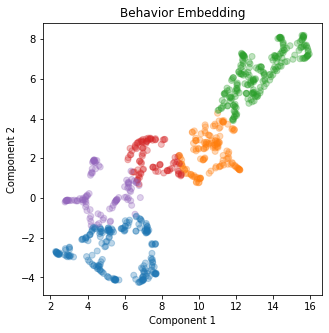

In [30]:
# color code the data in our embedding space according to their cluster
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(embedding[:,0], embedding[:,1], c=clusters, alpha=0.3, cmap=newcmp_scatter)

plt.xlabel("Component 1"); plt.ylabel("Component 2"); plt.title(f"Behavior Embedding")
plt.show()

## 4. Ethogram: Visualize the Results!

We did it! We computationally determined the different behaviors that the ant exhibits during the video, along with when they appear. The last question we have to ask ourselves, then, is: how should we visualize these results? We can use an ethogram! Please run the code below to have a look at how the ethogram illustrates the ant's behavior at every point in time over the course of the video.

(779, 5)


Text(0.5, 1.0, 'Ethogram')

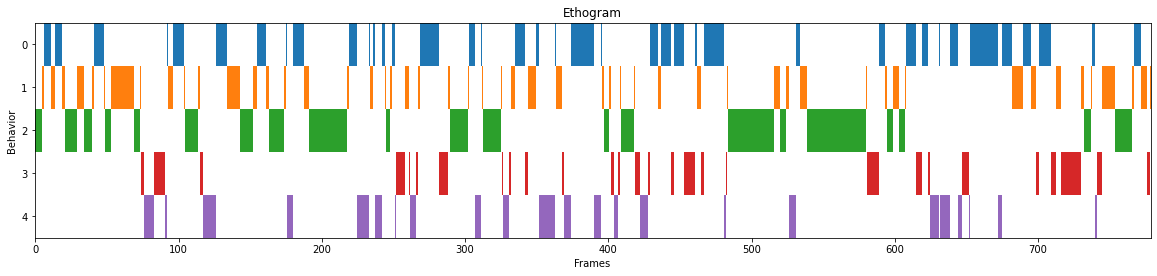

In [31]:
# One hot category of ethogram
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
one_hot_clusters = enc.fit_transform(clusters.reshape(-1, 1))
print(one_hot_clusters.shape)

# format ethogram data
ethogram_data = (clusters+1).reshape((-1,1))*one_hot_clusters

# plot ethogram
plt.figure(figsize=(20,8))
plt.imshow(ethogram_data.T, aspect=30, cmap=newcmp_etho, interpolation='nearest')
plt.xlabel("Frames"); plt.ylabel("Behavior"); plt.title(f"Ethogram")

Pretty neat, right?! We now have a graph that shows us which of our computationally determined behaviors the ant is performing over the course of the video!

In [32]:
# save your data!
np.save("clusters.npy", clusters)

<hr>
<strong>Created: </strong> July 30, 2020

<strong>Author: </strong> Dong Hur

<hr>
<strong>Revised: </strong> October 30, 2021

<strong>Author: </strong> Jonah Brenner
<center><h1>Reference</h1></center>


* Dataset from Professor Venkatesh Murthy's Lab (Harvard University Department of Molecular and Cellular Biology)